## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

Файл «sonnets.txt» уже существует — не загружается.



In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
rows = text

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = (''.join(text)).lower()  # Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = {el: idx for idx, el in enumerate(tokens)}  # Your great code here

# dict <char>:<index>
idx_to_token = {v: k for k, v in token_to_idx.items()} # Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
from random import sample
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

%matplotlib inline

In [9]:
def to_matrix(rows, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of rows into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, rows))
    rows_ix = np.zeros([len(rows), max_len], dtype) + pad

    for i in range(len(rows)):
        line_ix = [token_to_idx[c] for c in rows[i]]
        rows_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        rows_ix = np.transpose(rows_ix)

    return rows_ix

In [10]:
rows = [el.lower() for el in rows]
rows = [row for row in rows if len(row) > 13]
rows = [row.strip() + '\n' for row in rows]
rows = [' ' + ' '.join(rows[4 * i: 4*i+4]) for i in range(len(rows) // 4)]

print(rows[0])

 from fairest creatures we desire increase,
 that thereby beauty's rose might never die,
 but as the riper should by time decease,
 his tender heir might bear his memory:



Будем учить модель четверостишиями, в надежде на то, что она выучит переводы строк, пунктуацию и рифму.

max length = 209


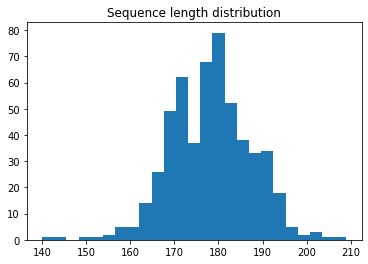

In [11]:
MAX_LENGTH = max(map(len, rows))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, rows)),bins=25);

### nn.RNN

In [57]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout=.7):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(
            input_size = emb_size,
            hidden_size = rnn_num_units,
            batch_first = True,
            num_layers = 2,
            dropout = dropout
        )
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden_state):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, hidden_state = self.rnn(self.emb(x), hidden_state)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden_state

In [58]:
model = CharRNNLoop(emb_size=32)
opt = torch.optim.Adam(model.parameters())
history = []

criterion = nn.NLLLoss()

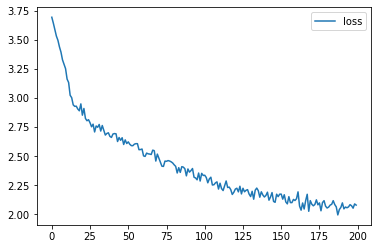

In [59]:
BATCH_SIZE = 16

for i in range(1000):
    batch_ix = to_matrix(sample(rows, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    hidden_state = torch.randn(2, BATCH_SIZE, 64)
    logp_seq = model(batch_ix, hidden_state)[0]
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [75]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_state = torch.randn(2, 1, 64)
    if len(seed_phrase) > 1:
        _, hidden_state = char_rnn(x_sequence[:, :-1], hidden_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_state = char_rnn(x_sequence[:, -1].view(1, 1), hidden_state)
        logp_next = logp_next[:, -1]
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [76]:
for _ in range(3):
    print(generate_sample(model, temperature=.6, max_length=400))
    print('-' * 100)

tensor([[ 1, 19, 16, 23, 23, 26]])


TypeError: view() missing 1 required positional arguments: "size"

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [156]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        assert isinstance(x.data, torch.LongTensor)
        if hidden:
            h, c = hidden
            h_seq, (h, c) = self.rnn(self.emb(x), (h, c))
        else :
            h_seq, (h, c) = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, (h, c)

In [157]:
model = CharRNNLoop(emb_size=32, rnn_num_units=128)
opt = torch.optim.Adam(model.parameters())
history = []
loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

In [158]:
BATCH_SIZE = 16

for i in range(2000):
    
    ## семплим похожие по длине строки
    ## так я хотел побороться с запробеливанием, так как в трейне получалось много пробелов подряд
    row_lens = [len(row) for row in rows]
    cur_len = sample(row_lens, 1)[0]
    cur_rows = [row for idx, row in enumerate(rows) if abs(len(row) - cur_len) <= 0]

    cur_delta = 1
    while len(cur_rows) < BATCH_SIZE:
        cur_rows += [row for idx, row in enumerate(rows) if cur_delta - 1 <= abs(len(row) - cur_len) <= cur_delta]
        cur_delta += 1
        
    
    batch_ix = to_matrix(sample(cur_rows, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, _ = model(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

KeyboardInterrupt: 

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    hidden = None
    
    if len(seed_phrase) > 1:
        _, hidden = char_rnn(x_sequence[:, :-1])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden = char_rnn(x_sequence[:, -1].view(1, 1), hidden)
        logp_next = logp_next[:, -1]
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(3):
    print(generate_sample(model, temperature=.6, max_length=200))
    print('-' * 100)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [147]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('--- temperature = {} ---'.format(temperature))
    print(generate_sample(model, temperature=temperature, max_length=200))
    print('-' * 100)

--- temperature = 0.1 ---
 the some thou art the sum thou art the stay
 the sum thou art the straines the strong thee,
                                                                                                           
----------------------------------------------------------------------------------------------------
--- temperature = 0.2 ---
 when i love the sum thou with the stall show,
 and thou art the sum that shall thou art thee,
                                                                                                         
----------------------------------------------------------------------------------------------------
--- temperature = 0.5 ---
 the sair mine is being all the porn all,
 and shall thou bear hell with thou art when to sel
 the self i with the beaute of thy spent:
 and i see, that i am which the cold with his self
             
----------------------------------------------------------------------------------------------------
--- temperature 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [142]:
torch.save(model.state_dict(), './model')

In [144]:
model = CharRNNLoop(emb_size=128)
model.load_state_dict(torch.load('./model'))

for _ in range(3):
    print(generate_sample(model, temperature=.6, max_length=200))
    print('-' * 100)

 but that i her death be and their stand
 thy shand and i stain this me so and shall the the vie deself the pire thy send have hath my of frowth of fair the beauty well i are the dear thee thou perres
----------------------------------------------------------------------------------------------------
 whoul and and the fair that that when that o cant the eyes of wer that not and worth that how with shourgh unfore to all thy lives.
                                                                   
----------------------------------------------------------------------------------------------------
 but what i so the searing she thy heart, and i hath love her though the stin the will sen i ever both of the then the i then be for my shall worse,
 and the gurtione,
 and to the your thy such i the 
----------------------------------------------------------------------------------------------------


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)